In [1]:
GAME = "frostbite"
IMAGE_W,IMAGE_H = IMAGE_SIZE =(105,80)
N_AGENTS = 10
SEQ_LENGTH = 5

In [2]:
from __future__ import print_function 
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%env THEANO_FLAGS="floatX=float32"

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


env: THEANO_FLAGS="floatX=float32"


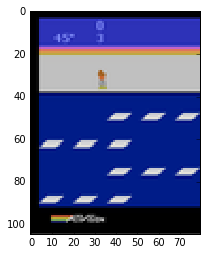

In [3]:
from env import Atari

#creating a game
atari = Atari(GAME,image_size=IMAGE_SIZE) 

action_names = np.array(atari.get_action_meanings())

obs = atari.step(0)[0]

plt.imshow(obs,interpolation='none')

In [4]:
from lasagne.layers import InputLayer, DimshuffleLayer

observation_layer = InputLayer((None,IMAGE_W,IMAGE_H,3))

observation_reshape = DimshuffleLayer(observation_layer,(0,3,1,2))


In [5]:
from lasagne.layers import Conv2DLayer,Pool2DLayer,DenseLayer,batch_norm,dropout, DropoutLayer

Convlayer1 = Conv2DLayer(incoming = observation_reshape,num_filters = 4, filter_size = (8,8), stride = (4,4))
Convlayer2 = Conv2DLayer(incoming = Convlayer1, num_filters = 4, filter_size = (4,4), stride = (2,2))
Denselayer1 = DenseLayer(incoming = Convlayer2, num_units = 10)

last_layer = Denselayer1

In [7]:
import lasagne
n_actions = atari.action_space.n
qvalues_layer = DenseLayer(incoming = Denselayer1, num_units = 6,nonlinearity=lasagne.nonlinearities.linear)

from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer,name="e-greedy action picker")

action_layer.epsilon.set_value(np.float32(0.1))

In [8]:
from agentnet.agent import Agent
agent = Agent(observation_layers=observation_layer,
              policy_estimators=qvalues_layer,
              action_layers=action_layer)

In [9]:
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[W, b, W, b, W, b, W, b]

In [10]:
from pool import AtariGamePool

pool = AtariGamePool(agent,GAME, N_AGENTS,image_size=IMAGE_SIZE)

In [11]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(7)


print(action_names[action_log])
print(reward_log)

[['DOWN' 'DOWN' 'DOWN' 'DOWN' 'DOWN' 'DOWN' 'DOWN']
 ['DOWN' 'DOWN' 'DOWN' 'DOWN' 'DOWN' 'DOWN' 'DOWN']
 ['RIGHT' 'DOWN' 'DOWN' 'DOWN' 'UP' 'DOWN' 'DOWN']
 ['DOWN' 'DOWN' 'DOWN' 'DOWN' 'UP' 'DOWN' 'DOWN']
 ['DOWN' 'UP' 'DOWN' 'DOWN' 'FIRE' 'DOWN' 'DOWN']
 ['DOWN' 'DOWN' 'DOWN' 'DOWN' 'DOWN' 'DOWN' 'RIGHT']
 ['DOWN' 'DOWN' 'DOWN' 'DOWN' 'DOWN' 'DOWN' 'DOWN']
 ['DOWN' 'RIGHT' 'DOWN' 'DOWN' 'DOWN' 'DOWN' 'DOWN']
 ['DOWN' 'DOWN' 'DOWN' 'DOWN' 'DOWN' 'DOWN' 'DOWN']
 ['DOWN' 'DOWN' 'UP' 'DOWN' 'DOWN' 'DOWN' 'DOWN']]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]
CPU times: user 368 ms, sys: 0 ns, total: 368 ms
Wall time: 436 ms


In [12]:
pool.update(SEQ_LENGTH)

In [13]:
replay = pool.experience_replay.sample_session_batch(100,replace=True)

_,_,_,_,qvalues_seq = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    optimize_experience_replay=True,
)


In [14]:
from agentnet.learning import qlearning


elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions,
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      gamma_or_gammas=0.99,)

loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [15]:
updates = lasagne.updates.sgd(loss,weights,learning_rate=0.01)

In [16]:
import theano
train_step = theano.function([],loss,updates=updates)

In [17]:
untrained_reward = pool.evaluate(save_path="./records",record_video=True)

[2016-10-28 20:12:36,194] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-28 20:12:36,195] Clearing 2 monitor files from previous run (because force=True was provided)
[2016-10-28 20:12:36,254] Starting new video recorder writing to /home/sdernal/Desktop/ML2016_fall/dqn_binder-master/records/openaigym.video.0.4918.video000000.mp4
[2016-10-28 20:12:46,908] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/sdernal/Desktop/ML2016_fall/dqn_binder-master/records')


Episode finished after 1171 timesteps with reward=180.0


In [18]:
from IPython.display import HTML

video_path = "./records/openaigym.video.0.4918.video000000.mp4"

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


In [20]:
def get_epsilon(epoch_counter):
    return 0.05 + 0.45*np.exp(-epoch_counter/1000.)

In [19]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {epoch_counter:untrained_reward}

In [ ]:
for i in xrange(500):        
    
    pool.update(SEQ_LENGTH)
    loss = train_step()
    
    current_epsilon = get_epsilon(epoch_counter)
    action_layer.epsilon.set_value(np.float32(current_epsilon))
    
    if epoch_counter%10==0:
        print("iter=%i\tepsilon=%.3f"%(epoch_counter,current_epsilon))
    
    ##record current learning progress and show learning curves
    if epoch_counter%100 ==0:
        rewards[epoch_counter] = pool.evaluate(record_video=False)
        
        plt.title("random frames")
        for i in range(min((len(pool.games),6))):
            plt.subplot(2,3,i+1)
            plt.imshow(pool.games[i].get_observation())
        plt.show()

    
    epoch_counter  +=1

iter=110	epsilon=0.453


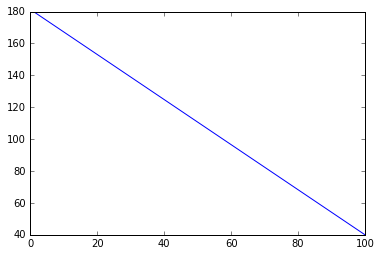

In [22]:
plt.plot(*zip(*sorted(list(rewards.items()),key=lambda p:p[0])))
    

In [23]:
action_layer.epsilon.set_value(0.001)
rw = pool.evaluate(n_games=20,save_path="./records",record_video=False)
print("mean session score=%f.5"%rw)

[2016-10-28 20:23:46,693] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-10-28 20:23:46,694] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 10001 timesteps with reward=0.0
Episode finished after 5176 timesteps with reward=0.0
Episode finished after 10001 timesteps with reward=10.0
Episode finished after 10001 timesteps with reward=0.0


KeyboardInterrupt: 

In [ ]:
from IPython.display import HTML

#select the one you want
video_path="./records/openaigym.video.0.13.video000000.mp4"

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))
